In [1]:
import random # random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accesso ai file
import datetime # dati temporali (date, ore)
import tensorflow as tf # Per creare reti neurali
import pandas as pd # Tabelle
import matplotlib # Grafici
import matplotlib.pyplot as plt #Grafici
import cv2 # Immagini
import keras # Semplifica la creazione di reti neurali
from keras.optimizers import Adam # allenatore
from sklearn.metrics import confusion_matrix
from tensorflow import keras # idem
from sklearn.model_selection import train_test_split # Divide i dati in training set e test set
from sklearn.preprocessing import LabelEncoder # Converte le parole in numeri ("Gatto" = 0, "Cane" = 1, ...)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Per gestire il dataset di immagini
from keras.models import Sequential # Per definire una rete neurale semplice, sequenziale
from tensorflow.keras import layers # I livelli di una rete neurale
from keras.layers import Dense, Dropout, Activation, Flatten # Componenti di una rete neurale
from keras.layers import Conv2D, MaxPooling2D # Convoluzioni e pooling
import seaborn as sns # Altri grafici
from sklearn.metrics import confusion_matrix # Per capire quanto è bravo il modello
from sklearn.utils import class_weight # Per bilanciare il dataset

In [11]:
def dataset(direct):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()
    
    train_dir = os.listdir(direct)
    for i in train_dir:
        if i == "Train_Test_Valid":
            continue
        class_path = os.path.join(direct, i)
        
        # 디렉터리인지 확인
        if os.path.isdir(class_path):
            classes.append(i)
            for j in os.listdir(class_path):
                file_path = os.path.join(class_path, j)
                img = cv2.imread(file_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, (224, 224))  # Resize image
                    img = img / 255.0  # Normalize
                    images.append(img)
                    labels.append(i)
                
    images = np.array(images)
    labels = label_encoder.fit_transform(labels)

    return images, labels, classes

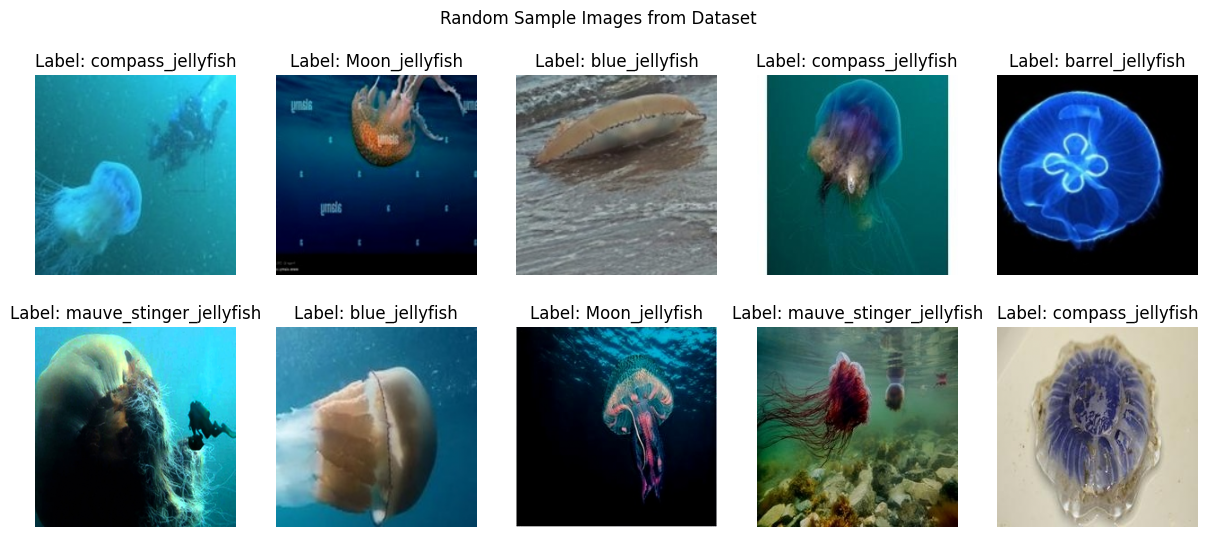

In [12]:

images, labels, classes = dataset('./jellyfish_data')

random_indexes = random.sample(range(len(images)), 10)

# Plot a few images at random indexes
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in zip(random_indexes, ax.flatten()):
    ax.imshow(images[idx])
    ax.set_title(f"Label: {classes[labels[idx]]}")
    ax.axis('off')
plt.suptitle('Random Sample Images from Dataset')
plt.show()

In [13]:
# Diviaimo il nostro dataset in training set (80%) e test set (20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# Poi dividiamo ulteriormente il training set (75%) per creare il "validation set" (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

classes = np.unique(classes)

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
)

test_val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=20)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=20)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=20, shuffle=False)

In [15]:
# Definiamo il modello
model = Sequential()

# Aggiungiamo il primo layer: puoi modificare i parametri, ma lascia invariato "input_shape=(224, 224, 3)""
model.add(Conv2D(16, 3, input_shape=(224, 224, 3), activation='relu'))

# Aggiungi gli altri layer che vuoi (Conv2D, MaxPooling2D)
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))

# Ora appiattiamo la rete e la facciamo diventare una rete neurale "classica"
model.add(Flatten())
          
# Aggiungi i livelli con i neuroni
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
          
# Ultimo layer, non toccarlo :)
model.add(Dense(6, activation='softmax'))
          
# Completiamo il modello: puoi cambiare il learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\envym\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,793,686 (10.66 MB)

 Trainable params: 2,793,686 (10.66 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    train_generator, 
    epochs=100, 
    validation_data=val_generator
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.7764 - loss: 0.5709 - val_accuracy: 0.7444 - val_loss: 0.8945
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.7857 - loss: 0.5322 - val_accuracy: 0.6389 - val_loss: 1.2351
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.7340 - loss: 0.6533 - val_accuracy: 0.6556 - val_loss: 0.9916
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.7796 - loss: 0.5814 - val_accuracy: 0.6889 - val_loss: 0.9259
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.7776 - loss: 0.5852 - val_accuracy: 0.7000 - val_loss: 0.9725
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.7908 - loss: 0.5132 - val_accuracy: 0.7444 - val_loss: 0.8248
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.7916 - loss: 0.5746 - val_accuracy: 0.7222 - val_loss: 1.0224
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.8149 - loss: 0.4628 - val_accu

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7942 - loss: 0.8134
Test Accuracy: 78.33%


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7942 - loss: 0.8134


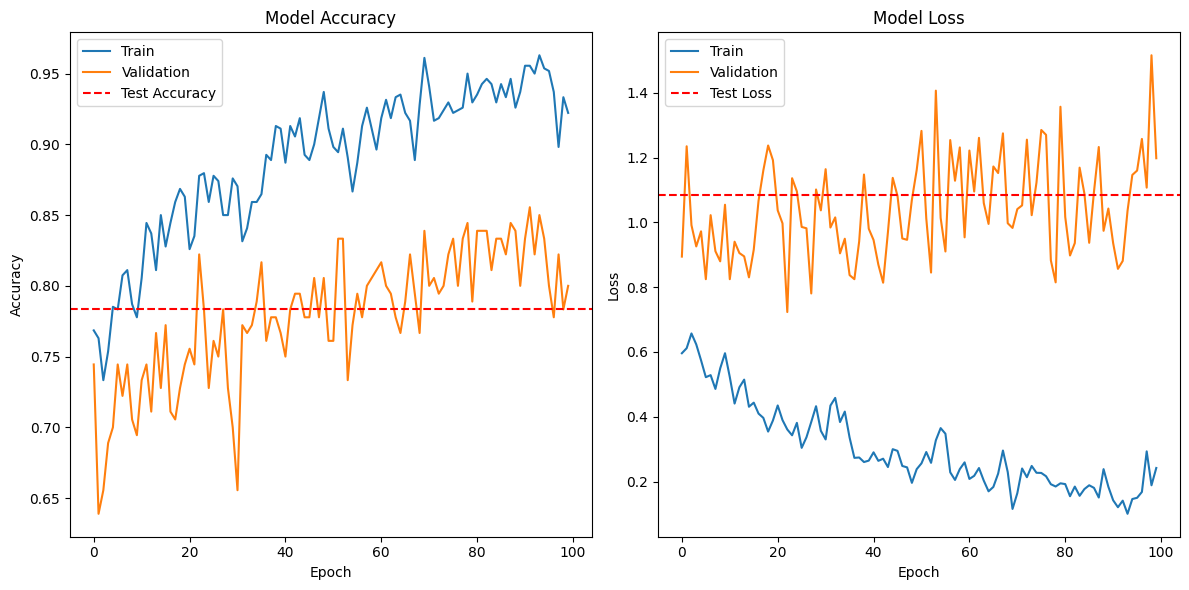

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

test_loss, test_accuracy = model.evaluate(test_generator)
plt.axhline(y=test_accuracy, color='r', linestyle='--')
plt.legend(['Train', 'Validation', 'Test Accuracy'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.axhline(y=test_loss, color='r', linestyle='--')
plt.legend(['Train', 'Validation', 'Test Loss'], loc='upper left')

plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


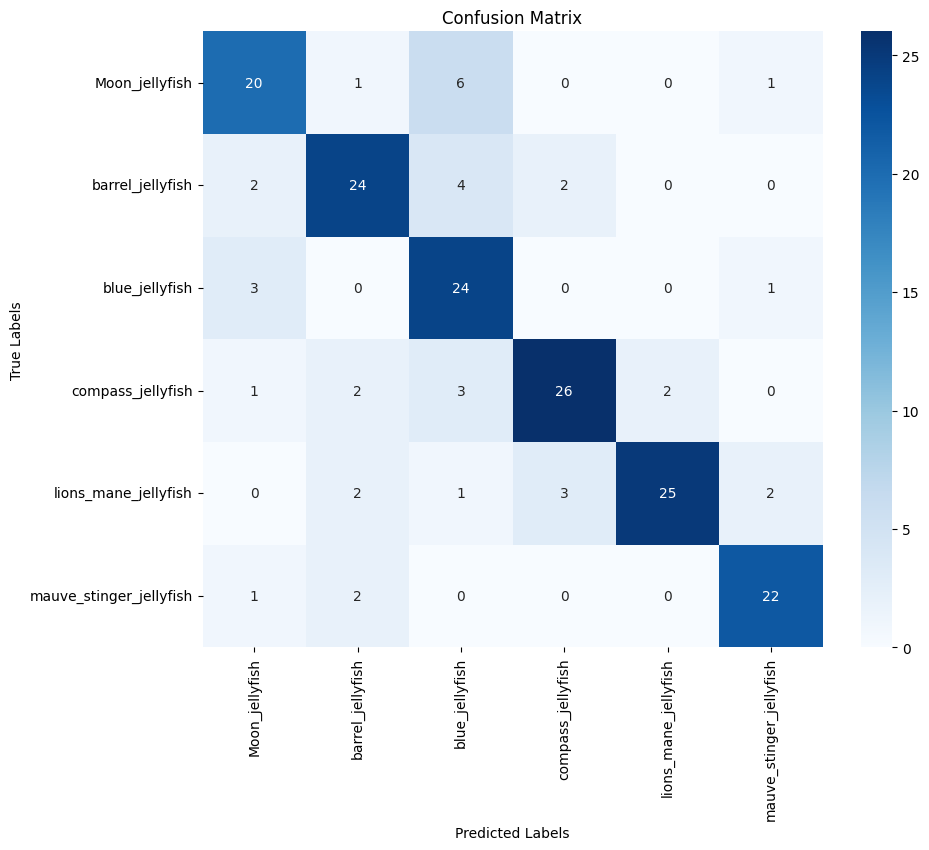

In [30]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = y_test

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()